# **Sentiment Analysis on Queen Elizabeth’s Death: Tweets from Around the World on Queen Elizabeth II.**
## This notebook contains experiments on unsupervised models including: clustering, LDA and lexicon based models using VADER and Textblob.

## Setting up pyspark, hadoop and java

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar -xvf spark-3.5.3-bin-hadoop3.tgz
!pip install findspark
!pip install spark-nlp==5.1.4
!wget -q https://dl.bintray.com/johnsnowlabs/spark-nlp/spark-nlp_2.12-5.1.4.jar
!pip install kagglehub
!pip install vaderSentiment

--2024-12-19 17:16:23--  https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.208.237, 135.181.214.104, 2a01:4f8:10a:39da::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.208.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400864419 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.3-bin-hadoop3.tgz’

spark-3.5.3-bin-had 100%[===================>] 382.29M   170KB/s    in 33m 48s 

2024-12-19 17:50:11 (193 KB/s) - ‘spark-3.5.3-bin-hadoop3.tgz’ saved [400864419/400864419]

spark-3.5.3-bin-hadoop3/
spark-3.5.3-bin-hadoop3/data/
spark-3.5.3-bin-hadoop3/data/graphx/
spark-3.5.3-bin-hadoop3/data/graphx/users.txt
spark-3.5.3-bin-hadoop3/data/graphx/followers.txt
spark-3.5.3-bin-hadoop3/data/mllib/
spark-3.5.3-bin-hadoop3/data/mllib/sample_linear_regression_data.txt
spark-3.5.3-bin-hadoop3/data/mllib/sample_fpgrowth.txt
spark-3.5.3-bin-hadoop3/data/mllib/sam

In [2]:
import kagglehub
import os
import findspark
from py4j.java_gateway import java_import
import pandas as pd
import numpy as np
import gensim

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, udf, regexp_replace, explode, desc
from pyspark.sql.types import IntegerType, StringType

from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml import Pipeline

from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import LDA
from pyspark.ml.evaluation import ClusteringEvaluator

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from gensim import corpora
from gensim.models import CoherenceModel

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import Tokenizer as NLPTokenizer, LemmatizerModel, StopWordsCleaner

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')




## Setting up Kaggle and Importing Data about Tweets on Queen Elizabeth's Death

In [3]:
path = kagglehub.dataset_download("aneeshtickoo/tweets-after-queen-elizabeth-iis-death")

print("Path to dataset files:", path)

100%|██████████| 28.4M/28.4M [00:00<00:00, 45.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aneeshtickoo/tweets-after-queen-elizabeth-iis-death/versions/1


## Creating Spark Session

In [4]:

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

findspark.init()
findspark.find()

spark = SparkSession.builder\
        .master("local")\
        .appName("Sentiment_Analysis_on_Queen_Elizabeths_Death")\
        .config('spark.ui.port', '4050')\
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.4")\
        .getOrCreate()

sc = spark.sparkContext

java_import(spark._sc._jvm, "org.apache.spark.sql.api.python.*")

## Reading the Dataset

In [5]:
file_path = f"{path}/queen.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.printSchema()
df.show(5, truncate=False)

root
 |-- id: string (nullable = true)
 |-- conversation_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- username: string (nullable = true)
 |-- name: string (nullable = true)
 |-- place: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- language: string (nullable = true)
 |-- mentions: string (nullable = true)
 |-- urls: string (nullable = true)
 |-- photos: string (nullable = true)
 |-- replies_count: string (nullable = true)
 |-- retweets_count: string (nullable = true)
 |-- likes_count: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- cashtags: string (nullable = true)
 |-- link: string (nullable = true)
 |-- retweet: string (nullable = true)
 |-- quote_url: string (nullable = true)
 |-- video: string (nullable = true)
 |-- thumbnail: string (nullable = true)
 |-- near: 

## Cleaning Data
To reduce noise and clean up the data we will remove:
1. Empty tweets
2. Non-English tweets
3. Duplicate tweets
4. Upper case
5. URLs
6. Mentions (@handles)
7. Hashtags (#)
8. Punctuation
</br>



In [6]:
# Remove rows with empty tweet
df = df.na.drop(subset=["tweet"])

# Remove non-English tweets
df = df.filter(col("language") == 'en')

# Remove duplicates based on the tweet text
df = df.dropDuplicates(["tweet"])

# Lowercase
df = df.withColumn("tweet", lower(col("tweet")))

# Remove URLs
df = df.withColumn("tweet", regexp_replace("tweet", r"http\S+", ""))

# Remove Mentions (@handles)
df = df.withColumn("tweet", regexp_replace("tweet", r"@[A-Za-z0-9_]+", ""))

# Remove Hashtags (#). This removes the '#' symbol only, leaving the word part of the hashtag.
df = df.withColumn("tweet", regexp_replace("tweet", "#", ""))

# Remove punctuation
# Keeping only letters, numbers, and whitespace. This regex means replace anything not a word char or space.
df = df.withColumn("tweet", regexp_replace("tweet", r"[^a-zA-Z0-9\s]", ""))

# Showing df after the above changes
df.show(5, truncate=False)


+-------------------+-------------------+---------------------------------------+----------+--------+--------+-------------------+---------------+----------------------------+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+--------+--------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+-------------+--------------+-----------+--------------------------------------------------------------+--------+--------------------------------------------------------------+-------+---------+-----+-----------------------------------------------+----+----+------+----------+-------+----------+--------+------------+---------+---------+---------

## Feature Engineering
Before running ML models like k-means and LDA we first to need to extract features.
* We need to convert text into numerical features.
* Convert raw tweets into a processed format using Spark NLP annotators.
* Tokenize text into words and remove stopwords (insignificant words like "the", "a" etc.)
* Lemmatization ensures that words like “running,” “runs,” and “ran” are all reduced to their base form “run,” which can improve cluster coherence.
* After preprocessing, CountVectorizer converts the tokens into numerical features that the models can handle.

In [7]:
# DocumentAssembler: create 'document' column from the 'tweet' column
documentAssembler = DocumentAssembler() \
    .setInputCol("tweet") \
    .setOutputCol("document")

# Tokenizer
sparkTokenizer = NLPTokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Remove stop words
stopWordsCleaner = StopWordsCleaner() \
    .setInputCols(["token"]) \
    .setOutputCol("cleanTokens") \
    .setCaseSensitive(False)

# Pretrained Lemmatizer model from Spark NLP
# Download will happen automatically if not already present
lemmatizer = LemmatizerModel.pretrained("lemma_antbnc") \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")

# Finisher to get the final tokens as normal strings
finisher = Finisher() \
    .setInputCols(["lemma"]) \
    .setOutputCols(["finalTokens"]) \
    .setCleanAnnotations(True)

# Convert tokens to feature vectors using CountVectorizer
countVectorizer = CountVectorizer(inputCol="finalTokens", outputCol="features", vocabSize=5000, minDF=5)

# Build the pipeline
pipeline = Pipeline(stages=[
    documentAssembler,
    sparkTokenizer,
    stopWordsCleaner,
    lemmatizer,
    finisher,
    countVectorizer
])

model = pipeline.fit(df)
transformed_df = model.transform(df)



lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


## Exploratory Data Analysis - Top 10 Words

In [8]:
# Explode the array of tokens so each token is in its own row
words_df = transformed_df.select(explode(col("finalTokens")).alias("word"))

# Group by the word and count occurrences
word_counts = words_df.groupBy("word").count()

# Order by frequency in descending order and show top 10
top_10_words = word_counts.orderBy(desc("count")).limit(10)

top_10_words.show(truncate=False)


+----------------+------+
|word            |count |
+----------------+------+
|queen           |155321|
|elizabeth       |128951|
|ii              |117163|
|queenelizabethii|34954 |
|majesty         |31262 |
|pass            |25120 |
|rest            |23611 |
|death           |22429 |
|family          |21346 |
|die             |21118 |
+----------------+------+



## Running K-Means Algorithm and Finding Optimal K-Value
The dataset is not labelled i.e. for each tweet there is no pre-defined sentiment label. We will try k-means clustering first to discover thematic groups (mourning, political critiques, historical context).

In [9]:
# Choose the number of clusters (k)
k = 5

# Create a KMeans object
kmeans = KMeans().setK(k).setSeed(1)

# Fit the model to transformed data
kmeans_model = kmeans.fit(transformed_df)

# Get cluster assignments for each data point
clustered_df = kmeans_model.transform(transformed_df)

# Show the results
clustered_df.show(5)

+-------------------+-------------------+--------------------+----------+--------+--------+-------------------+---------------+--------------------+-----+--------------------+--------+--------+--------------------+--------------------+-------------+--------------+-----------+--------------------+--------+--------------------+-------+---------+-----+--------------------+----+----+------+----------+-------+----------+--------+------------+---------+---------+----------+--------------------+--------------------+----------+
|                 id|    conversation_id|          created_at|      date|    time|timezone|            user_id|       username|                name|place|               tweet|language|mentions|                urls|              photos|replies_count|retweets_count|likes_count|            hashtags|cashtags|                link|retweet|quote_url|video|           thumbnail|near| geo|source|user_rt_id|user_rt|retweet_id|reply_to|retweet_date|translate|trans_src|trans_dest|  

### Silhouette Score
 The silhouette score measures how similar a data point is to its own cluster compared to other clusters. It ranges from -1 to +1, where a higher score indicates better clustering.

In [10]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(clustered_df)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.0746362929520554


### Testing Range of K-Values

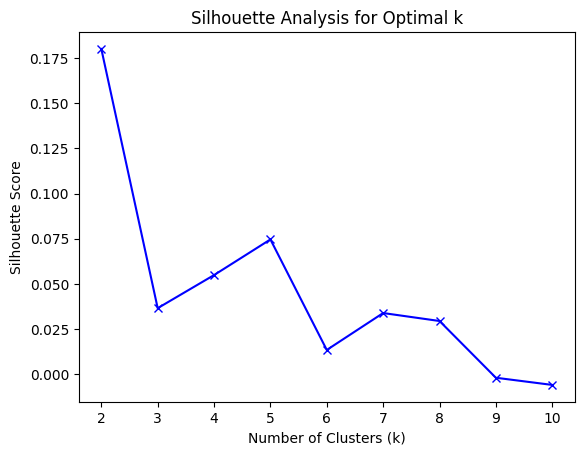

Optimal k based on silhouette analysis: 2


In [11]:
# Range of k values to test
k_values = range(2, 11)  # You can adjust the range

# Lists to store silhouette scores

silhouette_scores = []

# Loop through different k values
for k in k_values:
    # Create and fit KMeans model
    kmeans = KMeans().setK(k).setSeed(1)
    kmeans_model = kmeans.fit(transformed_df)

    # Calculate silhouette score
    clustered_df = kmeans_model.transform(transformed_df)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(clustered_df)
    silhouette_scores.append(silhouette)


# Plot silhouette scores
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

# Find optimal k based on silhouette scores
optimal_k_silhouette = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal k based on silhouette analysis: {optimal_k_silhouette}")

### Displaying Top 10 Clusters

In [12]:
cv_model = model.stages[-1]  # This is the CountVectorizerModel
vocab = cv_model.vocabulary
centers = kmeans_model.clusterCenters()


num_top_words = 10
for cluster_idx, center in enumerate(centers):
    # Get indices of top words by sorting the cluster center in descending order
    top_indices = np.argsort(center)[::-1][:num_top_words]
    top_words = [vocab[i] for i in top_indices]
    print(f"Cluster {cluster_idx} top words: {top_words}")




Cluster 0 top words: ['queen', 'elizabeth', 'ii', 'rest', 'majesty', 'peace', 'pass', 'queenelizabeth', 'rip', 'death']
Cluster 1 top words: ['queen', 'elizabeth', 'ii', 'monarch', 'britain', 'long', 'reign', 'british', 'die', 'longestreigning']
Cluster 2 top words: ['queen', 'die', 'elizabeth', 'ii', 'news', 'buckingham', '96', 'palace', 'announce', 'bbc']
Cluster 3 top words: ['queenelizabethii', 'queenelizabeth', 'rest', 'peace', 'rip', 'majesty', 'people', 'amp', 'world', 'death']
Cluster 4 top words: ['queen', 'elizabeth', 'ii', '96', 'age', 'die', 'monarch', 'year', '70', 'balmoral']
Cluster 5 top words: ['queen', 'elizabeth', 'iis', 'death', 'pass', 'news', 'life', 'follow', 'reign', 'royal']
Cluster 6 top words: ['queen', 'queenelizabethii', 'queenelizabeth', 'elizabethii', 'elizabeth', 'rest', 'death', 'rip', 'peace', 'world']
Cluster 7 top words: ['queen', 'elizabeth', 'ii', 'family', 'royal', 'majesty', 'condolence', 'pass', 'sadden', 'thoughts']
Cluster 8 top words: ['eliza

## Topic Modeling with LDA
Let's also explore the topics found by LDA and compare it to k-means.
<br>
In natural language processing, latent Dirichlet allocation (LDA) is a Bayesian network (and, therefore, a generative statistical model) for modeling automatically extracted topics in textual corpora. The LDA is an example of a Bayesian topic model. In this, observations (e.g., words) are collected into documents, and each word's presence is attributable to one of the document's topics. Each document will contain a small number of topics.

In [13]:
lda = LDA(seed=42, featuresCol='features', maxIter=10)
lda_model = lda.fit(transformed_df)

# Describe the topics
topics = lda_model.describeTopics(maxTermsPerTopic=10)
topics.show(truncate=False)

# Retrieve the vocabulary from the CountVectorizer model for interpretation
cv_model = model.stages[-1]   # This is the CountVectorizerModel
vocabulary = cv_model.vocabulary

# Print out the top words for each topic
for row in topics.collect():
    topic_id = row["topic"]
    term_indices = row["termIndices"]
    term_weights = row["termWeights"]
    top_terms = [vocabulary[i] for i in term_indices]
    print(f"Topic {topic_id}:")
    for term, weight in zip(top_terms, term_weights):
        print(f"{term}: {weight}")
    print("\n")


+-----+------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                 |termWeights                                                                                                                                                                                                                         |
+-----+------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[0, 1, 2, 7, 533, 114, 707, 744, 190, 86]                   |[0.02992476889839341, 0.02253054701869

### Evaluating LDA with Topic Coherence Metrics
Metrics like UMass, UCI, or NPMI topic coherence scores measure how frequently top terms of a topic co-occur and are semantically related, providing an indirect measure of topic quality.

In [14]:
# Converting to Gensim format to calculate coherence scores
# Step 1: Extract tokenized texts
tokenized_texts = transformed_df.select("finalTokens").rdd.flatMap(lambda row: row).collect()

# Step 2: Create Gensim Dictionary and Bag-of-Words Corpus
dictionary = corpora.Dictionary(tokenized_texts)
bow_corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_texts]

# Step 3: Prepare topics
topics_gensim = []
for row in topics.collect():
    topic_terms = [vocabulary[i] for i in row["termIndices"]]  # Top words for this topic
    topics_gensim.append(topic_terms)

# Step 4: Create a "pseudo" Gensim LDA model from Spark topics
gensim_lda_model = gensim.models.LdaModel(num_topics=len(topics_gensim), id2word=dictionary)

# Step 5: Evaluate Coherence Scores
# UMass Coherence (document-level word co-occurrence)
umass_coherence = CoherenceModel(topics=topics_gensim, corpus=bow_corpus, dictionary=dictionary, coherence='u_mass')
print(f"UMass Coherence Score: {umass_coherence.get_coherence()}")

# UCI Coherence (word co-occurrence across texts)
uci_coherence = CoherenceModel(topics=topics_gensim, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
print(f"UCI Coherence Score: {uci_coherence.get_coherence()}")

# NPMI Coherence (normalized pointwise mutual information)
npmi_coherence = CoherenceModel(topics=topics_gensim, texts=tokenized_texts, dictionary=dictionary, coherence='c_npmi')
print(f"NPMI Coherence Score: {npmi_coherence.get_coherence()}")


UMass Coherence Score: -3.9515793922190463
UCI Coherence Score: 0.4624213081140193
NPMI Coherence Score: 0.051441260112618695


## VADER
VADER Sentiment Analysis. VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains.
VADER performs best on raw text (with minimal cleaning, without tokenization or removing stopwords). So we will keep capitalization, punctuation (like exclamation marks) and emojis as these can convey emotion/sentiment.

In [15]:
# Create a df for VADER with minimal cleaning

df_VADER = spark.read.csv(file_path, header=True, inferSchema=True)
# Remove rows with empty tweet
df_VADER = df.na.drop(subset=["tweet"])
# Remove non-English tweets
df_VADER = df.filter(col("language") == 'en')
# Remove duplicates based on the tweet text
df_VADER = df.dropDuplicates(["tweet"])
# Remove URLs
df_VADER = df.withColumn("tweet", regexp_replace("tweet", r"http\S+", ""))

# Use VADER to assign sentiment labels
analyzer = SentimentIntensityAnalyzer()

# Domain-specific rule:
mourning_words = ["condolences", "grief", "mourning", "sad", "loss"]

def custom_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']

    if any(word in text.lower() for word in mourning_words):
        # If the text has mourning-related words, classify it as "Mourning"
        return "Mourning"

    # Otherwise, rely on VADER's standard classification
    if compound > 0.05:
        return "Positive"
    elif compound < -0.05:
        return "Negative"
    else:
        return "Neutral"


sentiment_udf = udf(custom_sentiment, StringType())

vader_df_with_sentiment = df_VADER.withColumn("vader_sentiment", sentiment_udf(col("tweet")))
vader_df_with_sentiment.select("tweet", "vader_sentiment").show(10, truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|tweet                                                                                                                                                                                                                                                                                    |vader_sentiment|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|here at catfoss we are deeply saddened by last nights news of the passing of her majesty queen eliz

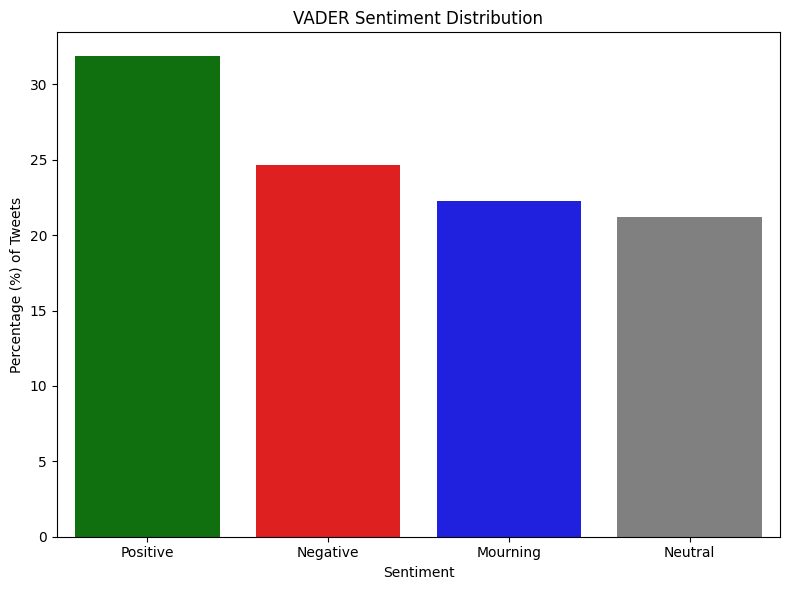

In [16]:
# Visualizing VADER Sentiment Classification Distribution

# Count how many tweets fall into each sentiment category
vader_sentiment_counts = vader_df_with_sentiment.groupBy("vader_sentiment").count()

# Convert to Pandas for plotting
sentiment_pdf = vader_sentiment_counts.toPandas()

vader_total = sentiment_pdf["count"].sum()
sentiment_pdf["percentage"] = (sentiment_pdf["count"] / vader_total) * 100

# Sort by percentage descending
sentiment_pdf = sentiment_pdf.sort_values("percentage", ascending=False)

# Define a color map for each sentiment category
color_map = {
    "Positive": "green",
    "Negative": "red",
    "Mourning": "blue",
    "Neutral": "gray",
}

# Map the sentiment column to colors
colors = sentiment_pdf["vader_sentiment"].map(color_map).tolist()

plt.figure(figsize=(8,6))
sns.barplot(x="vader_sentiment", y="percentage", data=sentiment_pdf, palette=colors)
plt.title("VADER Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Percentage (%) of Tweets")
plt.tight_layout()
plt.show()




## TextBlob
Let's compare VADER's results with TextBlob. TextBlob is a Python library for processing textual data. It provides a consistent API for diving into common natural language processing (NLP) tasks including sentiment analysis. TextBlob provides a polarity score (ranging from -1 to 1) and a subjectivity score, but most commonly we focus on polarity. We can classify the sentiment based on polarity thresholds similar to VADER.
* TextBlob tends to be more conservative and often classifies text as neutral if polarity is close to zero.
* Unlike VADER, TextBlob does not take capitalization, punctuation, or emojis into account explicitly. It uses a lexicon-based approach for polarity.




In [17]:
def textblob_sentiment(text):
    if text is None:
        return "Neutral"

    # Check for mourning words first
    text_lower = text.lower()
    if any(m_word in text_lower for m_word in mourning_words):
        # If present, classify as "Mourning"
        return "Mourning"

    # If no mourning words found, rely on TextBlob
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity

    # Set polarity thresholds
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

textblob_udf = udf(textblob_sentiment, StringType())

df_with_textblob = df.withColumn("textblob_sentiment", textblob_udf(col("tweet")))
df_with_textblob.select("tweet", "textblob_sentiment").show(10, truncate=False)



+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|tweet                                                                                                                                                                                                                                                                                    |textblob_sentiment|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|here at catfoss we are deeply saddened by last nights news of the passing of her majesty q

In [18]:
# Compare results of VADER and TextBlob
comparison_df = vader_df_with_sentiment.join(df_with_textblob.select("id", "textblob_sentiment"), on="id", how="inner")
comparison_df.select("tweet", "vader_sentiment", "textblob_sentiment").show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+------------------+
|tweet                                                                                                                                                                                                                                        |vader_sentiment|textblob_sentiment|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+------------------+
|  elizabeth ii britains longestserving monarch dies aged 96    queenelizabethii charles dinalipi                                                                              

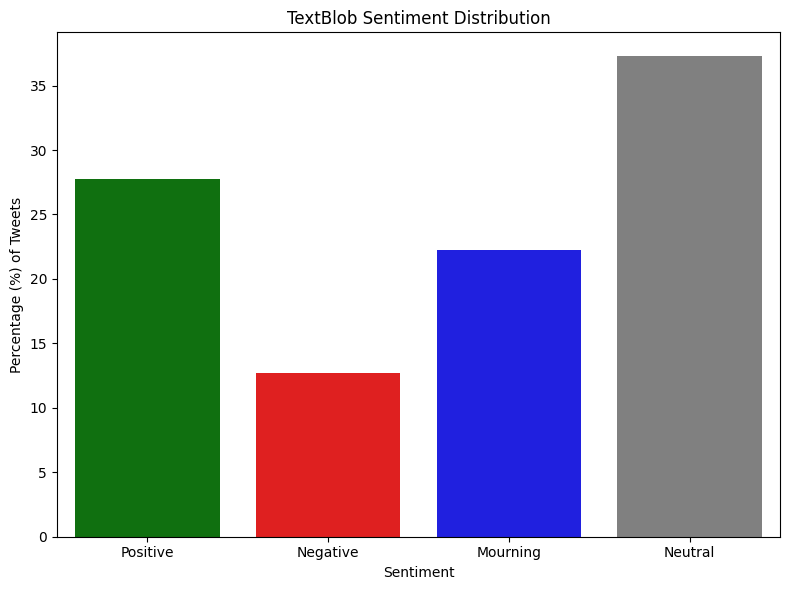

In [19]:
# Visualizing TextBlob Sentiment Classification Distribution

textblob_counts = df_with_textblob.groupBy("textblob_sentiment").count()
textblob_pdf = textblob_counts.toPandas()

# Specify order of sentiments on x-axis
sentiment_order = ["Positive", "Negative", "Mourning", "Neutral"]

# Define a color map for each sentiment category
color_map = {
    "Positive": "green",
    "Negative": "red",
    "Mourning": "blue",
    "Neutral": "gray",
}

# Convert to categorical with defined order
textblob_pdf["textblob_sentiment"] = pd.Categorical(textblob_pdf["textblob_sentiment"],
                                          categories=sentiment_order,
                                          ordered=True)

# Now sort by this categorical order
textblob_pdf = textblob_pdf.sort_values("textblob_sentiment")

total = textblob_pdf["count"].sum()
textblob_pdf["percentage"] = (textblob_pdf["count"] / total) * 100

colors = textblob_pdf["textblob_sentiment"].map(color_map).tolist()
plt.figure(figsize=(8,6))
sns.barplot(x="textblob_sentiment", y="percentage", data=textblob_pdf, palette=colors)
plt.title("TextBlob Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Percentage (%) of Tweets")
plt.tight_layout()
plt.show()


## Comparing VADER vs TextBlob

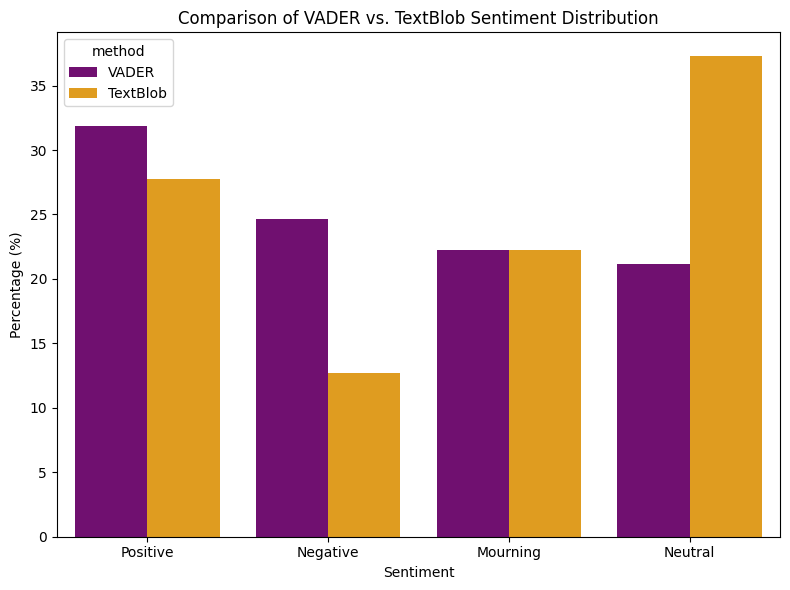

In [20]:
textblob_pdf = textblob_pdf.rename(columns={"textblob_sentiment": "sentiment"})
sentiment_pdf = sentiment_pdf.rename(columns={"vader_sentiment": "sentiment"})

sentiment_pdf["method"] = "VADER"
textblob_pdf["method"] = "TextBlob"

combined_df = pd.concat([sentiment_pdf[["sentiment", "percentage", "method"]],
                         textblob_pdf[["sentiment", "percentage", "method"]]], ignore_index=True)
## Desired order
sentiment_order = ["Positive", "Negative", "Mourning", "Neutral"]

# Convert to categorical with defined order
combined_df["sentiment"] = pd.Categorical(combined_df["sentiment"],
                                          categories=sentiment_order,
                                          ordered=True)

# Now sort by this categorical order
combined_df = combined_df.sort_values("sentiment")
color_map = {
    "VADER": "purple",
    "TextBlob": "orange"
}
plt.figure(figsize=(8,6))
sns.barplot(x="sentiment", y="percentage", hue="method", data=combined_df, palette=color_map)

plt.title("Comparison of VADER vs. TextBlob Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Percentage (%)")
plt.tight_layout()
plt.show()






## Evaluating VADER and Textblob Performance using Human Inspection/Heuristics on a Small Randomly Sampled Set

In [21]:
# Tweets with clear sentiment for heuristic evaluation (extracted from the dataset)
heuristic_examples = [
    ("this profile will now enter a 10 day period of mourning in tribute of queen elizabeth ii", "Mourning"),
    ("black twitter completely unbothered by queen elizabeth iis death", "Negative"),
    ("top story uk and world react to death of queen elizabeth ii  bbc news   see more ", "Neutral"),
    ("queen elizabeth ii thank you for your dedication to public service  an inspiration to us all  ", "Positive"),
    ("live condolences pour in from across globe for queenelizabethii demise  queenelizabeth queen restinpeaceyourmajesty  ", "Mourning")
]

# Convert the examples to a DataFrame for Spark processing
heuristic_df = spark.createDataFrame(heuristic_examples, ["tweet", "expected_sentiment"])


# Apply VADER sentiment analysis
heuristic_with_vader = heuristic_df.withColumn("vader_sentiment", sentiment_udf(col("tweet")))

# Apply TextBlob sentiment analysis
heuristic_with_sentiments = heuristic_with_vader.withColumn("textblob_sentiment", textblob_udf(col("tweet")))

# Compare expected sentiment with VADER and TextBlob outputs
comparison_df = heuristic_with_sentiments.select(
    "tweet", "expected_sentiment", "vader_sentiment", "textblob_sentiment"
)

# Show mismatches
comparison_df.withColumn(
    "vader_match", col("expected_sentiment") == col("vader_sentiment")
).withColumn(
    "textblob_match", col("expected_sentiment") == col("textblob_sentiment")
).show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------+------------------+---------------+------------------+-----------+--------------+
|tweet                                                                                                                |expected_sentiment|vader_sentiment|textblob_sentiment|vader_match|textblob_match|
+---------------------------------------------------------------------------------------------------------------------+------------------+---------------+------------------+-----------+--------------+
|this profile will now enter a 10 day period of mourning in tribute of queen elizabeth ii                             |Mourning          |Mourning       |Mourning          |true       |true          |
|black twitter completely unbothered by queen elizabeth iis death                                                     |Negative          |Negative       |Negative          |true       |true       